# EEG data preparation

In [1]:
# Based on:
#https://www.kaggle.com/code/abhishekinnvonix/artifact-detection-using-ica-mne-python-epilepsy
#https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
#https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/13.time-series-human_activity_recognition.ipynb 
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/ 

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from time import time
import pandas as pd


In [6]:
for dirname, _, filenames in os.walk('dbs_005'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dbs_005\f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_09-49-35_med_off.eeg
dbs_005\f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_09-49-35_med_off.vhdr
dbs_005\f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_09-49-35_med_off.vmrk
dbs_005\f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_10-53-29_med_on.eeg
dbs_005\f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_10-53-29_med_on.vhdr
dbs_005\f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_10-53-29_med_on.vmrk


In [28]:

directory_of_this_script = os.path.dirname(os.path.abspath(os.getcwd()))
file_path_no_med = os.path.join("dbs_003/70d91607-328d-fb1f-6a00-818614779e77__2024-02-21_10-37-36_med_off.vhdr")
file_path_with_med = os.path.join("dbs_003/70d91607-328d-fb1f-6a00-818614779e77__2024-02-21_11-47-24_med_on.vhdr")


In [29]:
'''
directory_of_this_script = os.path.dirname(os.path.abspath(os.getcwd()))
file_path_no_med = os.path.join("dbs_004/b6556a9e-56b4-653e-2a23-be9d623ca505__2024-04-24_08-51-47_med_off.vhdr")
file_path_with_med = os.path.join("dbs_004/b6556a9e-56b4-653e-2a23-be9d623ca505__2024-04-24_09-34-39_med_on.vhdr")
'''

'\ndirectory_of_this_script = os.path.dirname(os.path.abspath(os.getcwd()))\nfile_path_no_med = os.path.join("dbs20240424/patient20240424_-_2024-04-24_08-51-47_med_off.vhdr")\nfile_path_with_med = os.path.join("dbs20240424/patient20240424_-_2024-04-24_09-34-39_med_on.vhdr")\n'

In [30]:
'''
directory_of_this_script = os.path.dirname(os.path.abspath(os.getcwd()))
file_path_no_med = os.path.join("dbs_005/f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_09-49-35_med_off.vhdr")
file_path_with_med = os.path.join("dbs_005/f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_10-53-29_med_on.vhdr")
'''

'\ndirectory_of_this_script = os.path.dirname(os.path.abspath(os.getcwd()))\nfile_path_no_med = os.path.join("dbs20240221/Butrimaviciene_-_2024-02-21_10-37-36_no_med.vhdr")\nfile_path_with_med = os.path.join("dbs20240221/Butrimaviciene_-_2024-02-21_11-47-24_with_med.vhdr")\n'

In [31]:
raw_no_med = mne.io.read_raw_brainvision(file_path_no_med, preload=True)
raw_no_med.load_data()
info_no_med = raw_no_med.info

print(info_no_med['sfreq'], 'Hz')
print(info_no_med['chs'][0])

#######

raw_with_med = mne.io.read_raw_brainvision(file_path_with_med, preload=True)
raw_with_med.load_data()
info_with_med = raw_with_med.info

print(info_with_med['sfreq'], 'Hz')
print(info_with_med['chs'][0])

1024.0 Hz
{'ch_name': 'Fp1', 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'logno': 1, 'scanno': 1, 'cal': 1.0, 'range': 1e-06, 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit': 107 (FIFF_UNIT_V), 'unit_mul': 0 (FIFF_UNITM_NONE), 'coord_frame': 4 (FIFFV_COORD_HEAD)}
1024.0 Hz
{'ch_name': 'Fp1', 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'logno': 1, 'scanno': 1, 'cal': 1.0, 'range': 1e-06, 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'unit': 107 (FIFF_UNIT_V), 'unit_mul': 0 (FIFF_UNITM_NONE), 'coord_frame': 4 (FIFFV_COORD_HEAD)}


In [32]:
raw_no_med.set_channel_types({'EOG': 'eog'});
raw_with_med.set_channel_types({'EOG': 'eog'});

In [34]:
raw_no_med.crop(0, 298) # keeps the first 5 minutes of data and discards the rest
raw_with_med.crop(0, 298) # keeps the first 5 minutes of data and discards the rest

<RawBrainVision | f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_10-53-29_with_med.eeg, 64 x 305153 (298.0 s), ~149.1 MB, data loaded>

Filter the EEG data to remove unwanted frequency components using a bandpass filter.
Visualize a subset of EEG channels to get an overview of the data.

In [35]:
raw_no_med.filter(0.5,40)
raw_with_med.filter(0.5,40)

<RawBrainVision | f6c7f0b3-76bb-f13a-be91-d9e74eabfeb1__2024-05-07_10-53-29_with_med.eeg, 64 x 305153 (298.0 s), ~149.1 MB, data loaded>

In [36]:
raw_no_med.plot_psd(fmax=180);

In [37]:
raw_with_med.plot_psd(fmax=180);

In [38]:
#raw_no_med.notch_filter(50)
#raw_with_med.notch_filter(50)

In [39]:
raw_no_med.notch_filter(freqs=[16.667, 50]); # bandstop the train and power grid

In [40]:
raw_with_med.notch_filter(freqs=[16.667, 50]); # bandstop the train and power grid

Additional code for bad electrodes

In [41]:
#raw_no_med['bads'].extend(['AF4'])
#raw_with_med['bads'].extend(['AF4'])

In [42]:
print(raw_no_med.info['bads'])
print(raw_with_med.info['bads'])

[]
[]


Perform Independent Component Analysis (ICA) on the filtered EEG data to separate the independent components.

In [43]:
def run_ica(raw, method, fit_params=None):
    ica = ICA(n_components=20, method=method, fit_params=fit_params,
              max_iter='auto', random_state=0)
    t0 = time()
    ica.fit(raw)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)

Visualize the independent components obtained from ICA to inspect their time courses and scalp topographies.

In [44]:
montage = mne.channels.read_custom_montage('standard_1020.elc')

raw_no_med.set_montage(montage);
raw_with_med.set_montage(montage);

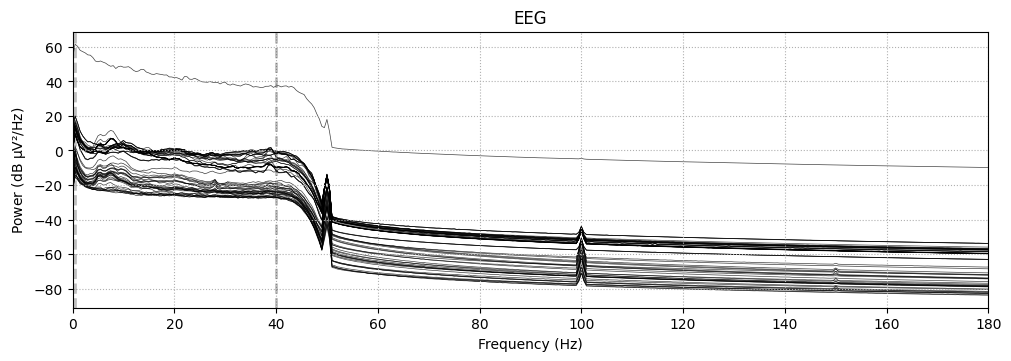

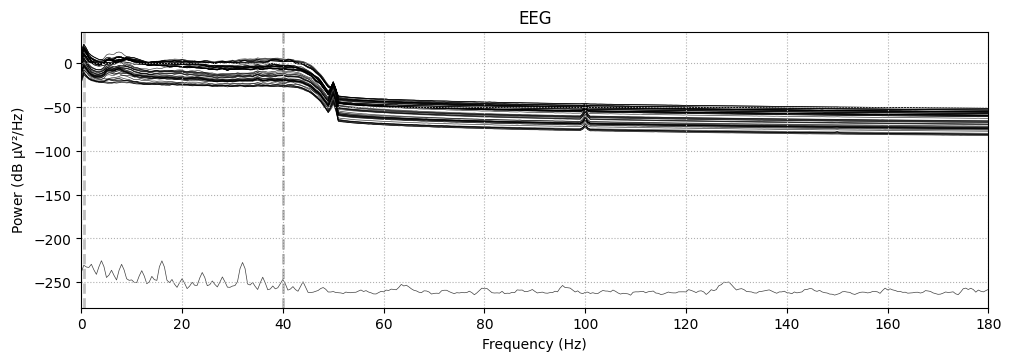

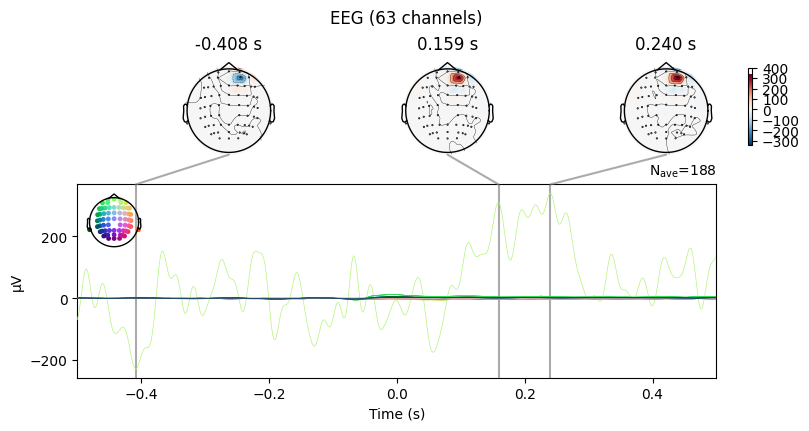

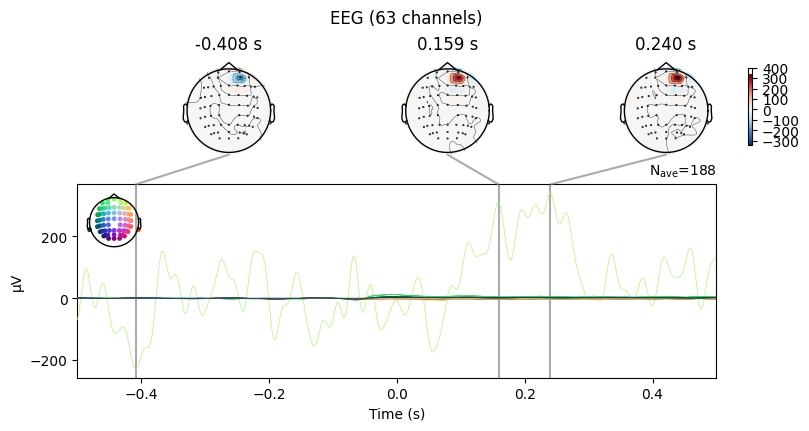

In [45]:
# epochs_with_med = Epochs(raw_with_med, events)

eog_evoked_no_med = create_eog_epochs(raw_no_med, ch_name=['EOG']).average()
eog_evoked_no_med.apply_baseline(baseline=(None, -0.2))
eog_evoked_no_med.plot_joint()

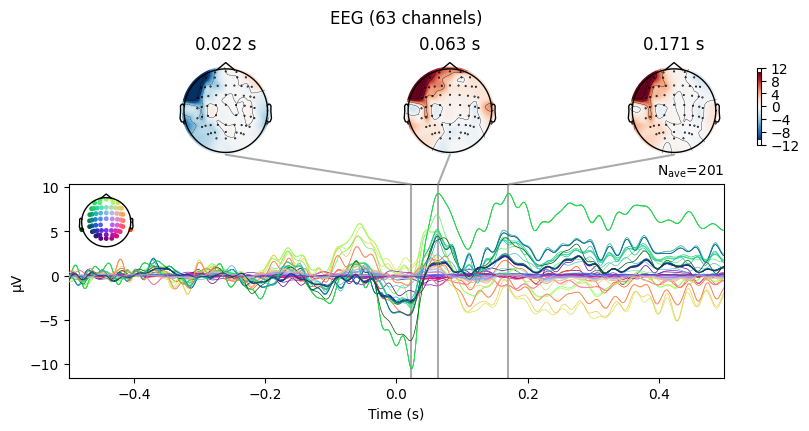

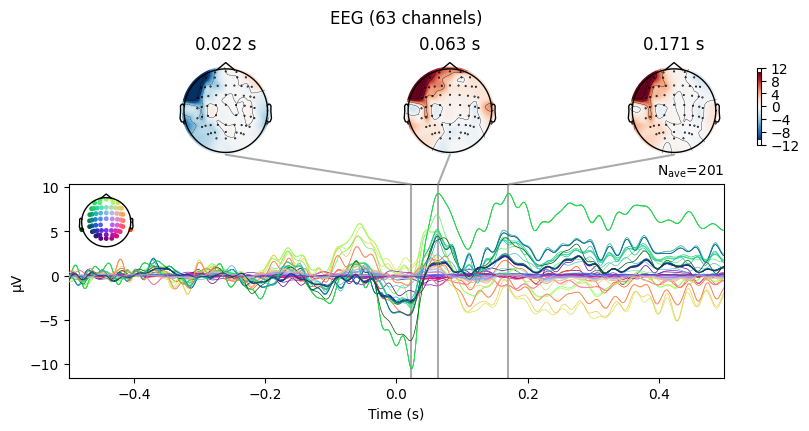

In [46]:
# epochs_with_med = Epochs(raw_with_med, events)

eog_evoked_with_med = create_eog_epochs(raw_with_med, ch_name=['EOG']).average()
eog_evoked_with_med.apply_baseline(baseline=(None, -0.2))
eog_evoked_with_med.plot_joint()

Select specific independent components that are likely to contain artifacts based on visual inspection.

>  Reconstruct the EEG data by excluding the selected artifact components.

In [47]:
filt_raw_no_med = raw_no_med.copy()
# filt_raw = raw_no_med.copy()

ica_no_med = ICA(n_components=25, max_iter='auto',method = 'fastica', random_state=97)
print ("ICA function")
ica_no_med.fit(filt_raw_no_med)
ica_no_med
print ("ICA Done")


ICA function
ICA Done


In [48]:
filt_raw_with_med = raw_with_med.copy()
# filt_raw = raw_with_med.copy()

ica_with_med = ICA(n_components=25, max_iter='auto',method = 'fastica', random_state=97)
print ("ICA function")
ica_with_med.fit(filt_raw_with_med)
ica_with_med
print ("ICA Done")

ICA function
ICA Done


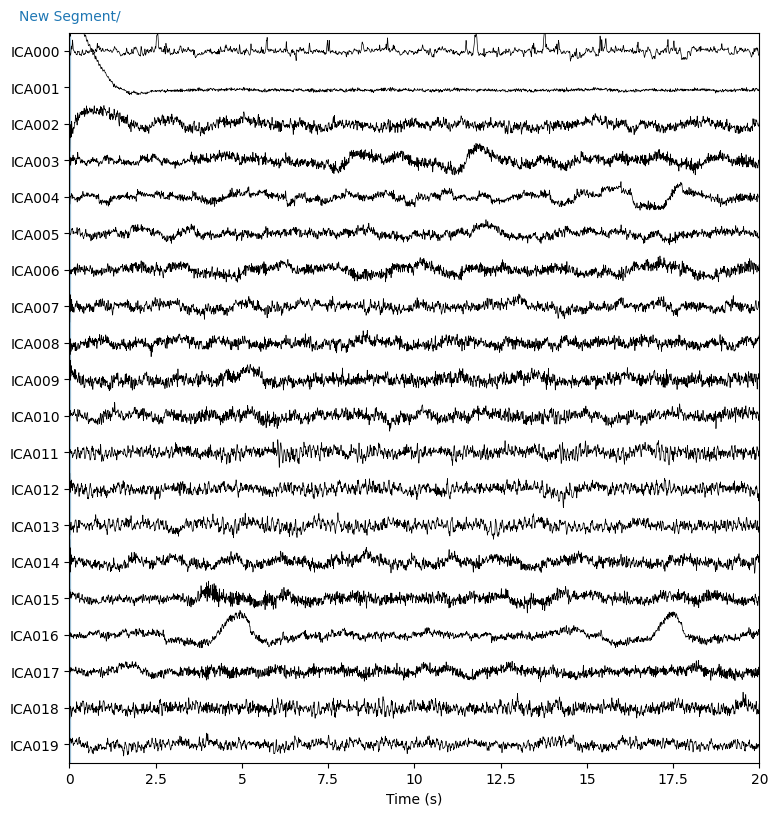

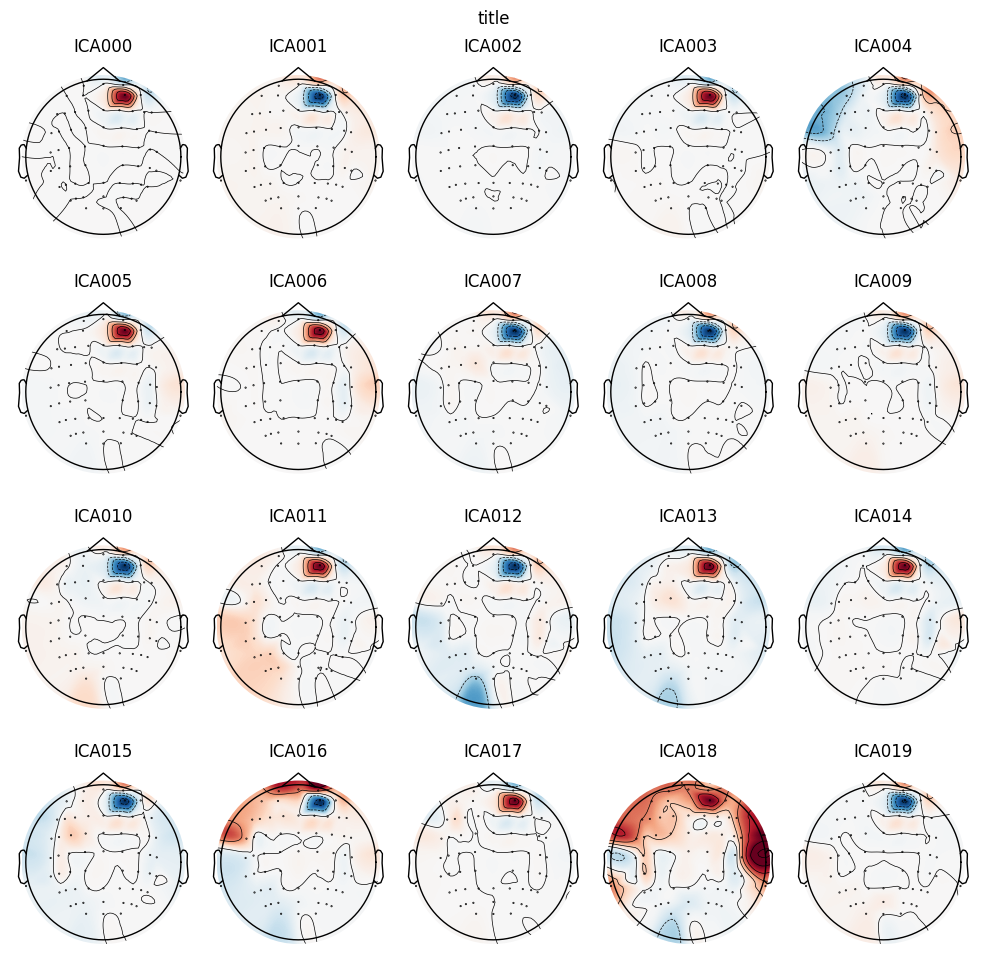

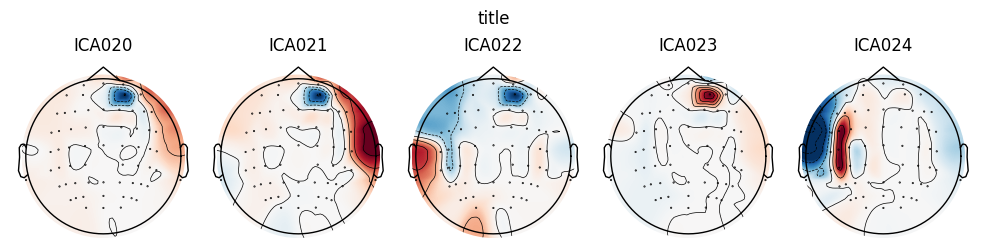

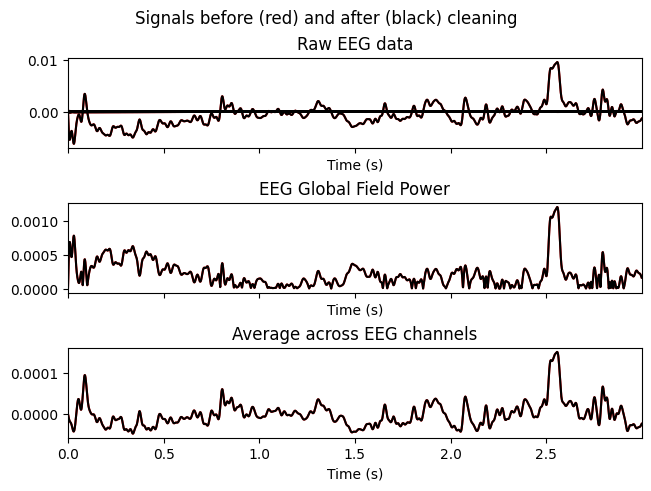

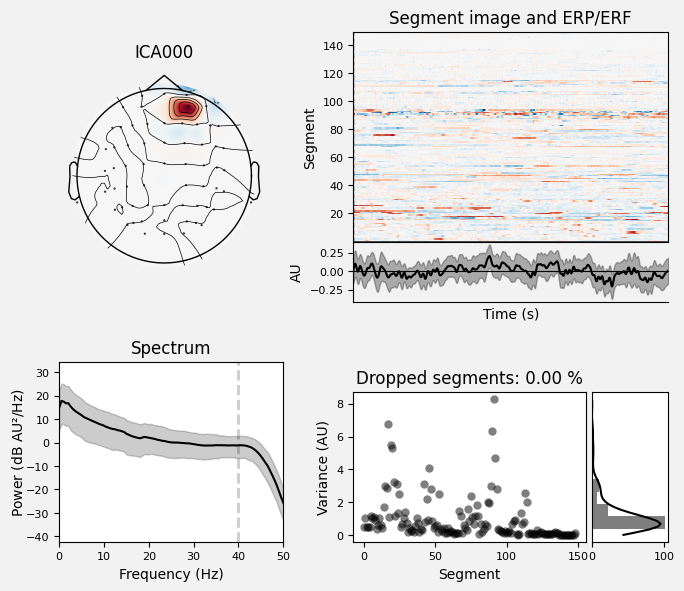

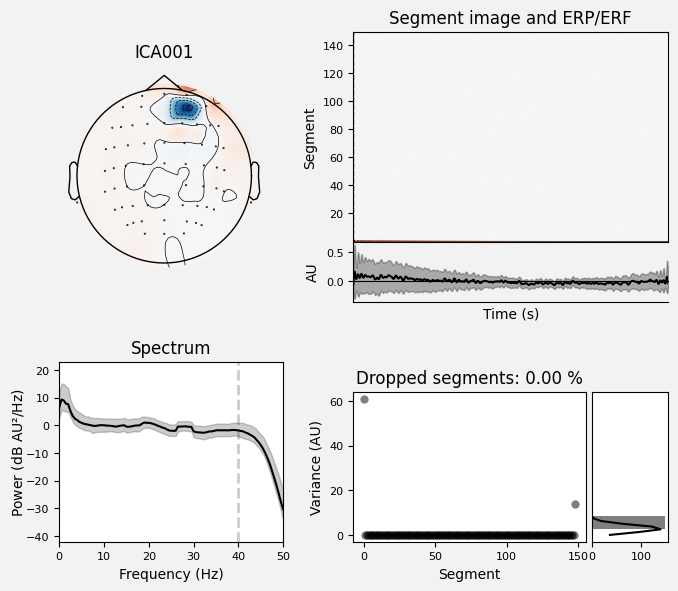

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [49]:
raw_no_med.load_data()
ica_no_med.plot_sources(raw_no_med, show_scrollbars=False)
ica_no_med.plot_components(title="title")

# blinks
ica_no_med.plot_overlay(raw_no_med, picks='eeg')

ica_no_med.plot_properties(raw_no_med, picks=[0, 1])


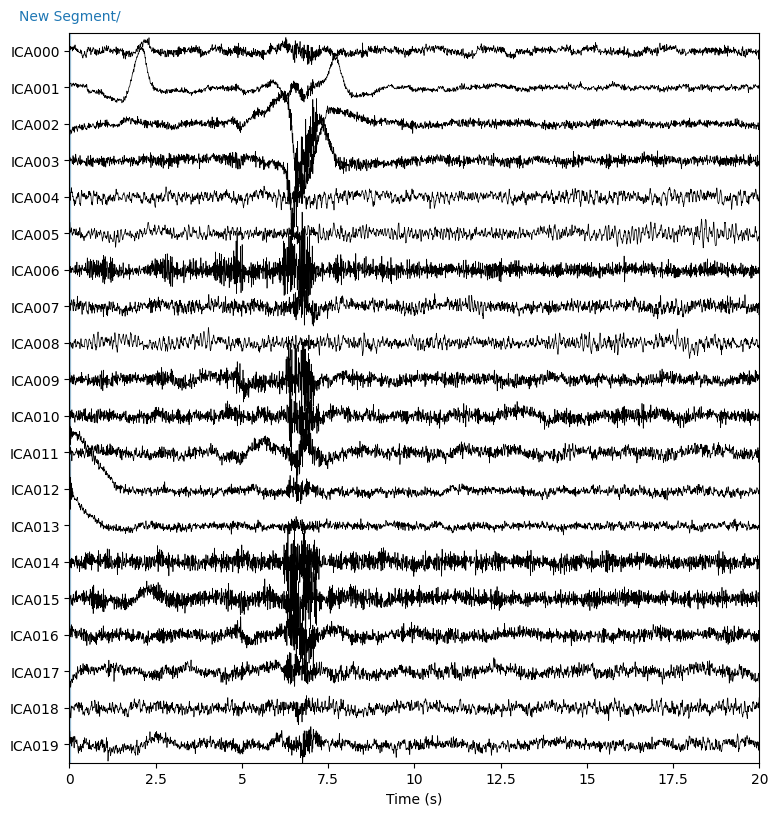

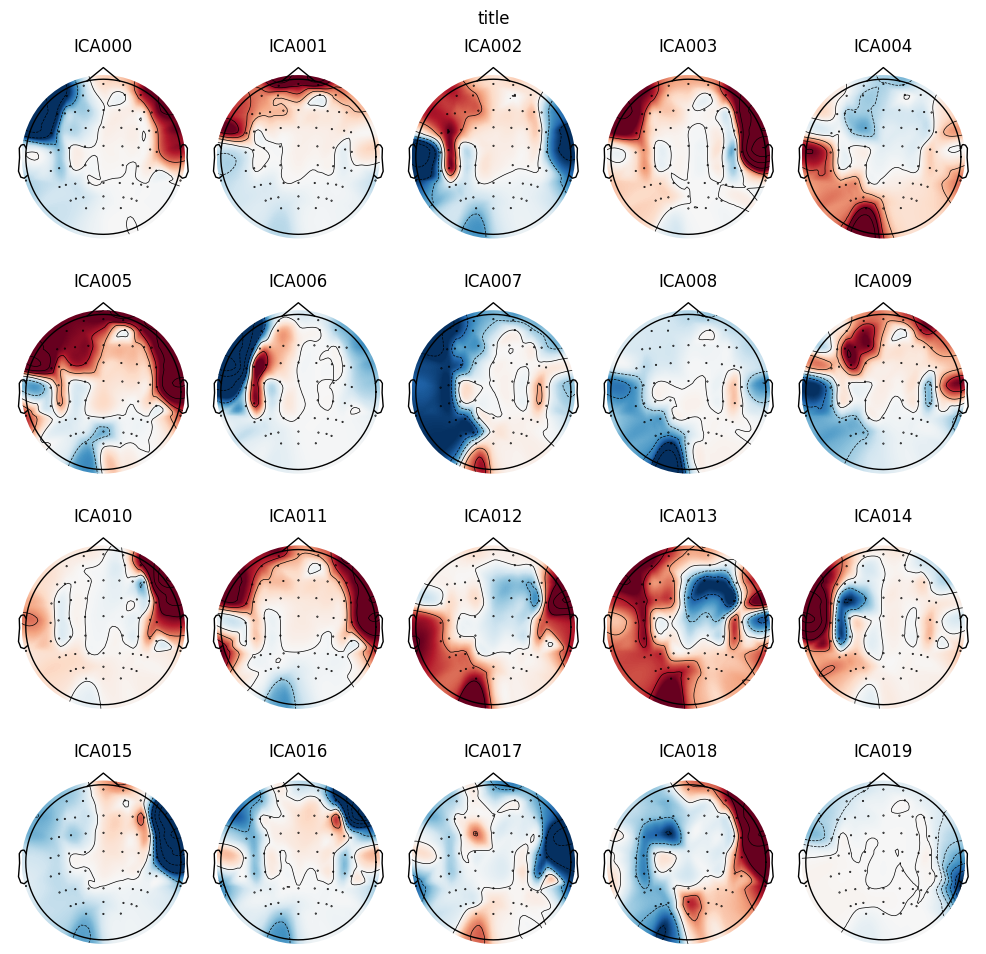

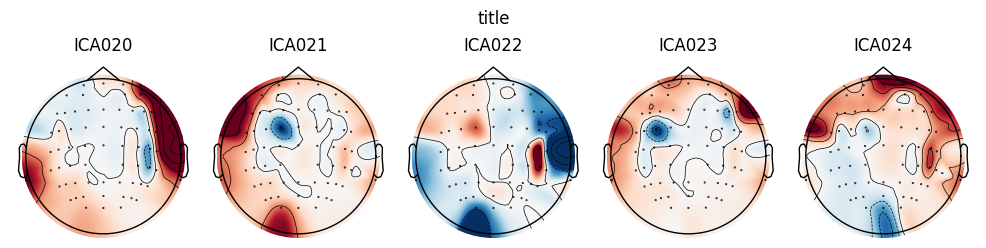

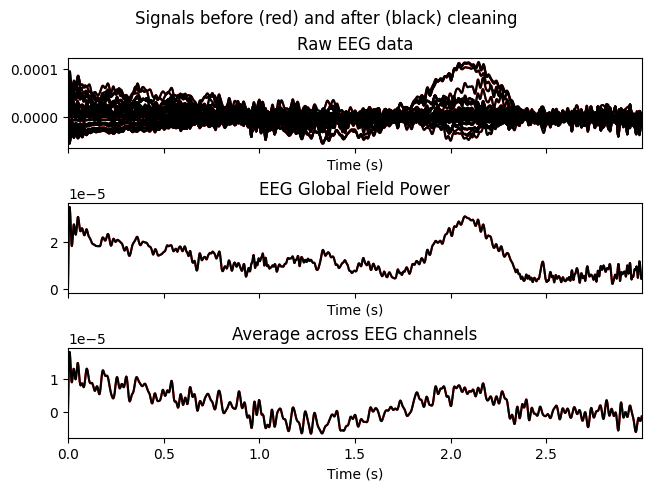

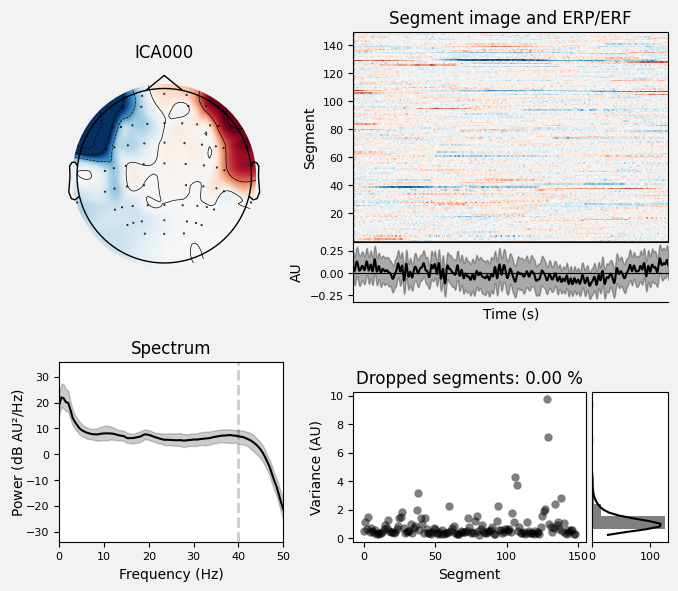

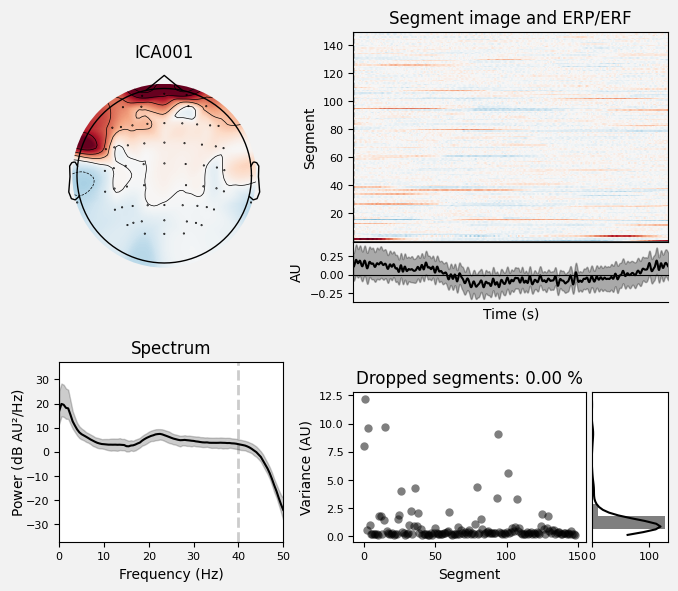

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [50]:
raw_with_med.load_data()
ica_with_med.plot_sources(raw_with_med, show_scrollbars=False)
ica_with_med.plot_components(title="title")

# blinks
ica_with_med.plot_overlay(raw_with_med, picks='eeg')

ica_with_med.plot_properties(raw_with_med, picks=[0, 1])

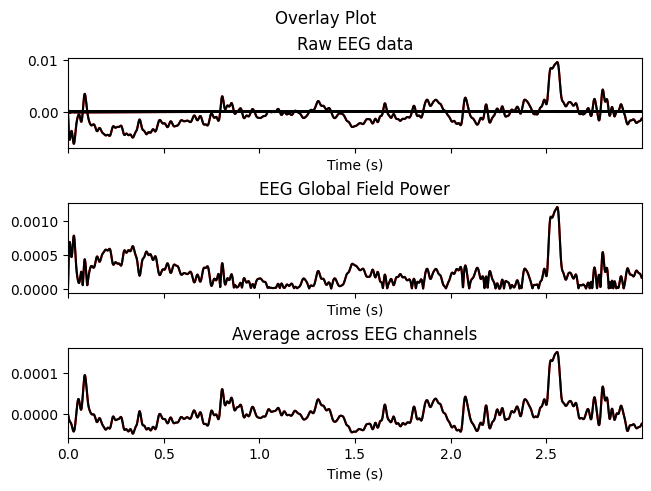

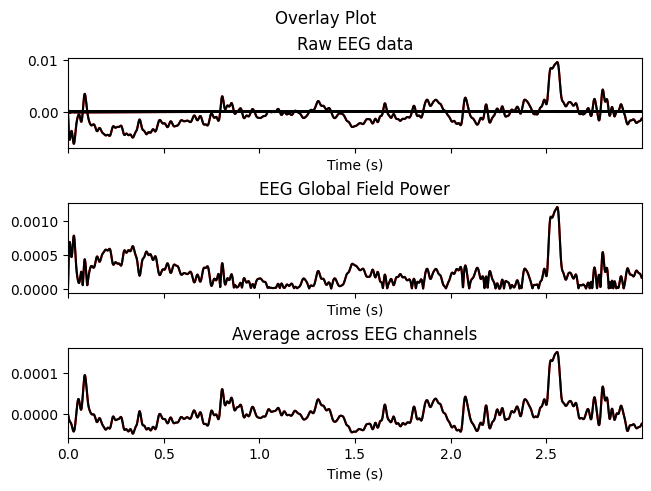

In [51]:
reconst_raw_no_med = raw_no_med.copy()
raw_no_med.load_data()
ica_no_med.apply(reconst_raw_no_med, n_pca_components =15, )
ica_no_med.plot_overlay(reconst_raw_no_med,title = "Overlay Plot")

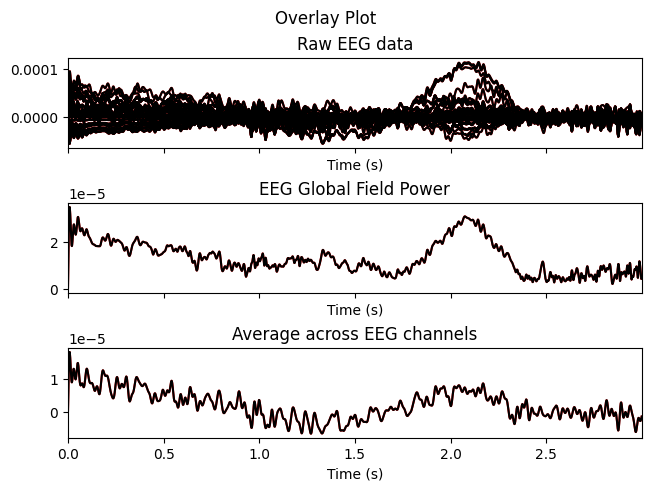

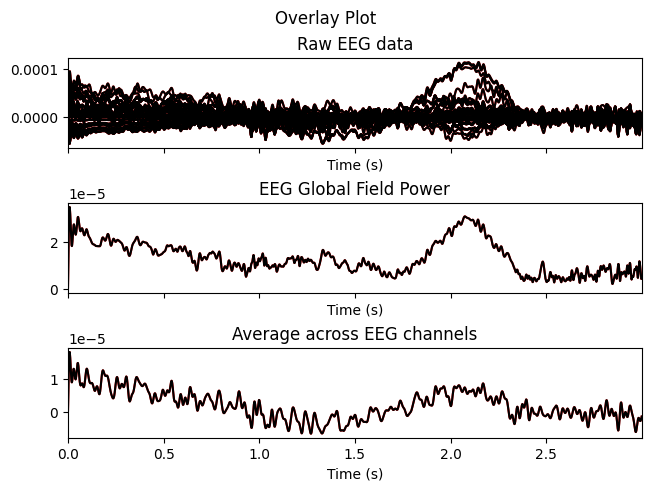

In [52]:
reconst_raw_with_med = raw_with_med.copy()
raw_with_med.load_data()
ica_with_med.apply(reconst_raw_with_med, n_pca_components =15, )
ica_with_med.plot_overlay(reconst_raw_with_med,title = "Overlay Plot")

Visualize the reconstructed EEG data to observe the removal of artifacts.

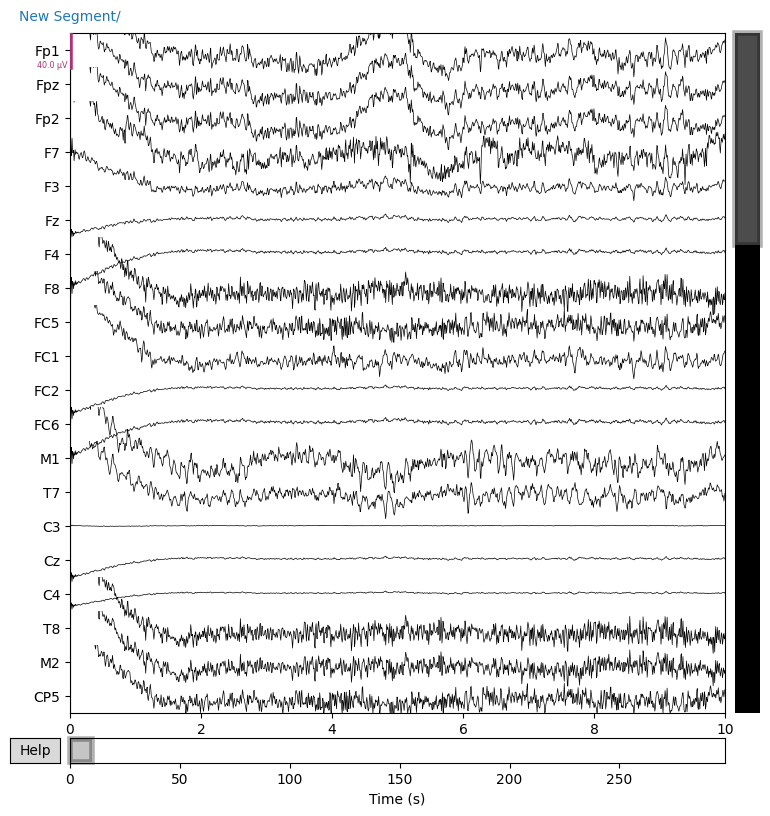

In [53]:
reconst_raw_no_med.plot(title = "Filtered plot")
#raw_no_med.plot(title = "Original plot")
plt.show()


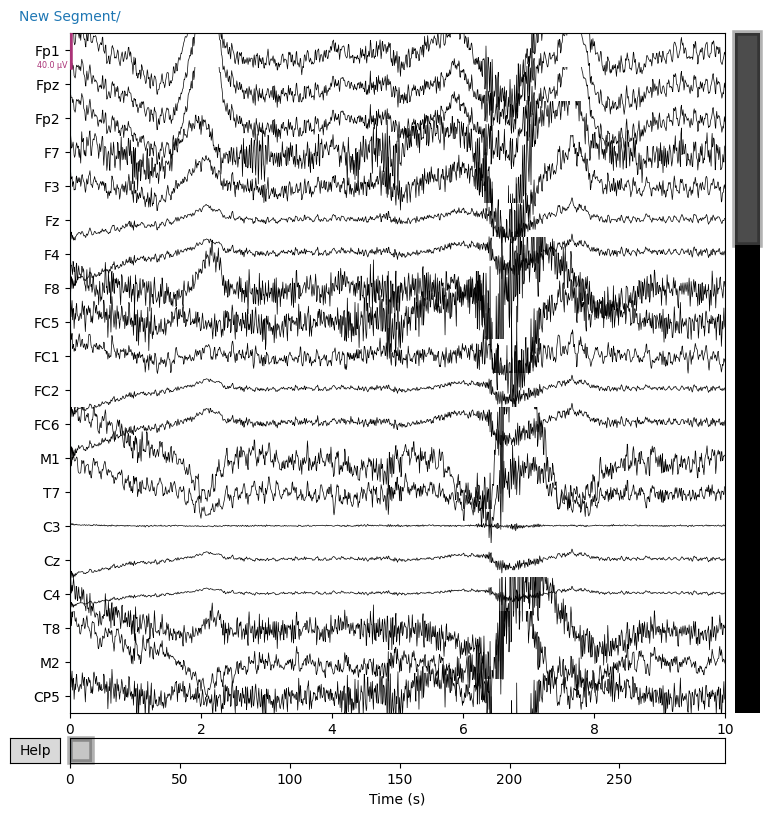

In [54]:
reconst_raw_with_med.plot(title = "Filtered plot")
#raw_with_med.plot(title = "Original plot")
plt.show()

# Plot freqs

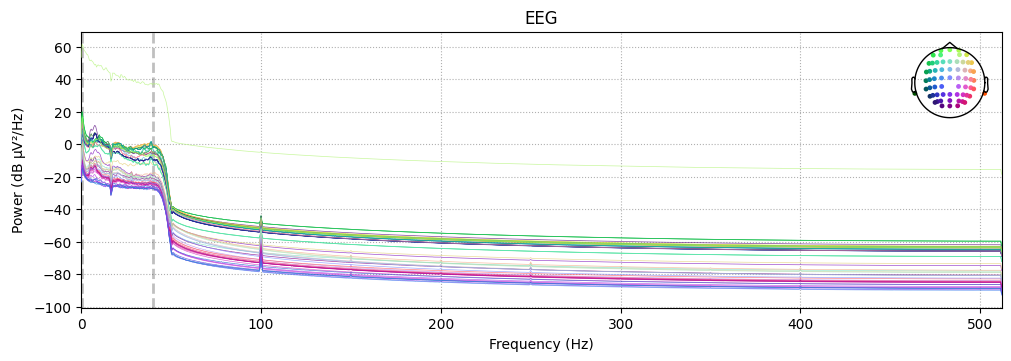

In [55]:
raw_no_med.plot_psd()

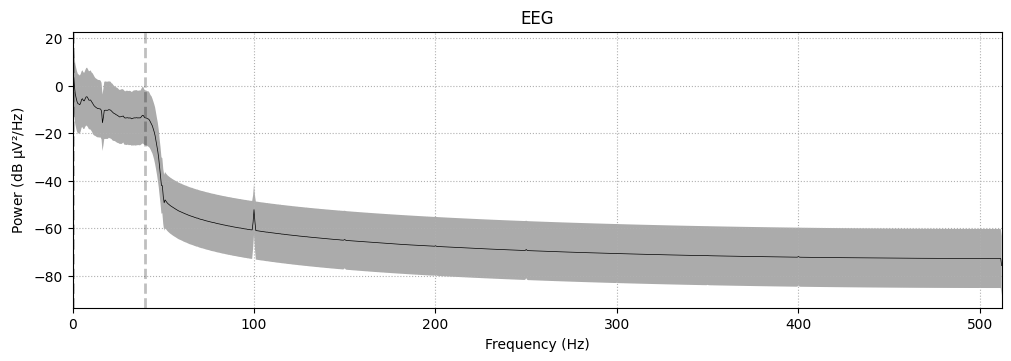

In [56]:
raw_no_med.plot_psd(average=True)

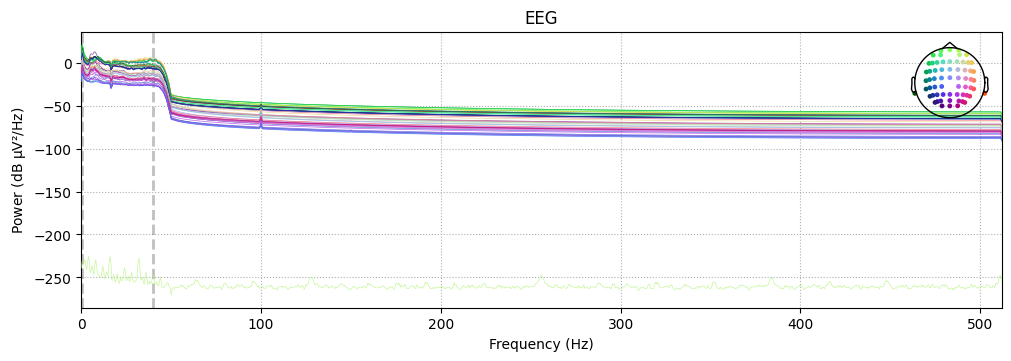

In [57]:
raw_with_med.plot_psd()

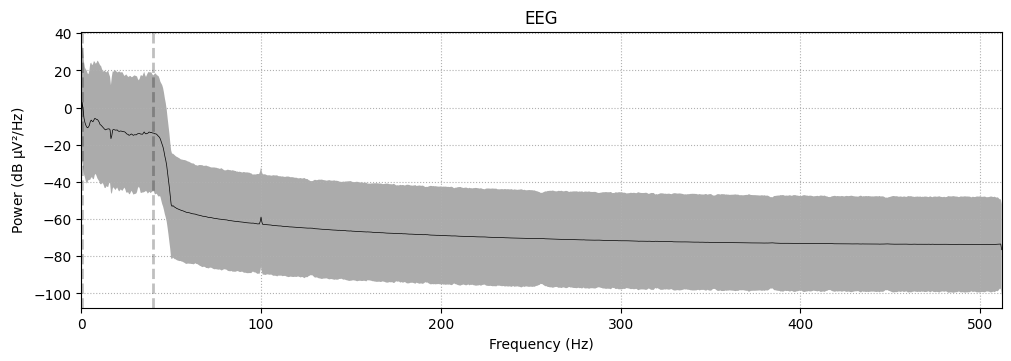

In [58]:
raw_with_med.plot_psd(average=True)

# Apply filter

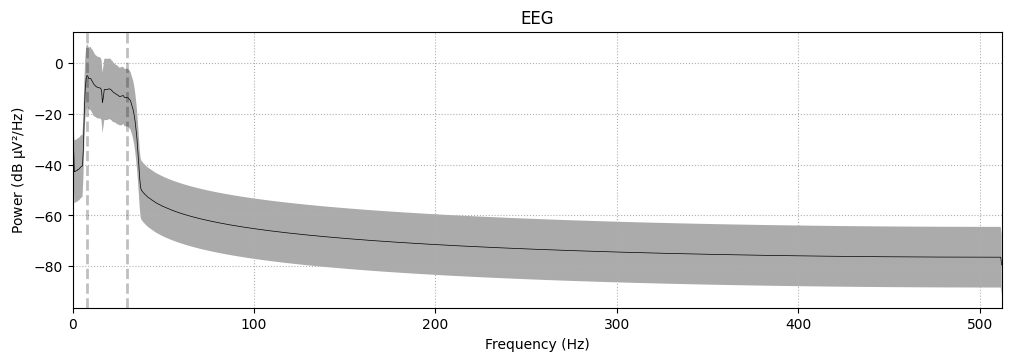

In [59]:
raw_filtered_no_med = raw_no_med.copy().filter(8,30, verbose=False)
raw_filtered_no_med.plot_psd()
raw_filtered_no_med.plot_psd(average=True)

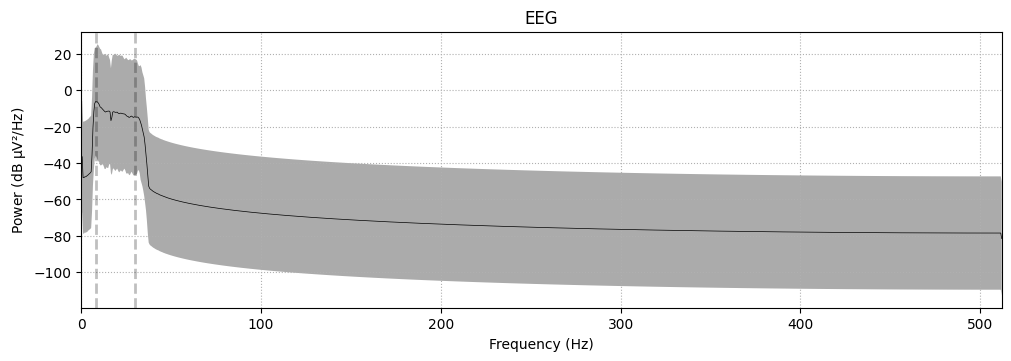

In [60]:
raw_filtered_with_med = raw_with_med.copy().filter(8,30, verbose=False)
raw_filtered_with_med.plot_psd()
raw_filtered_with_med.plot_psd(average=True)

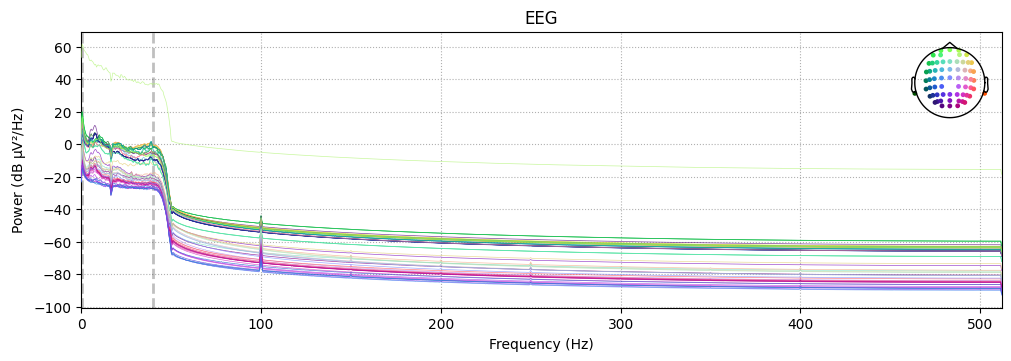

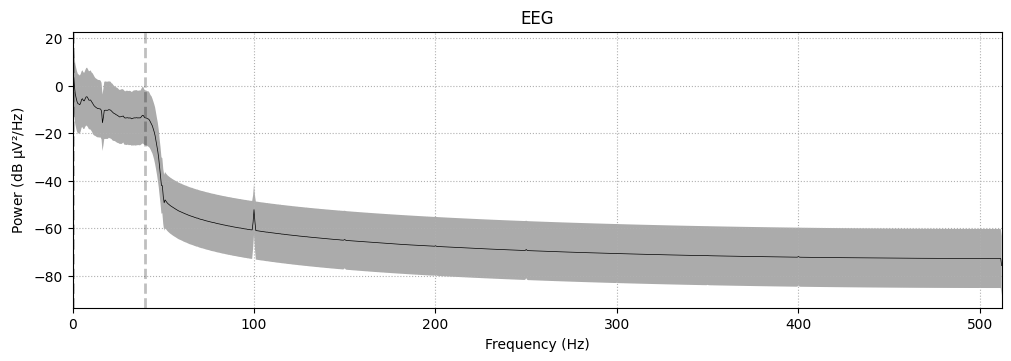

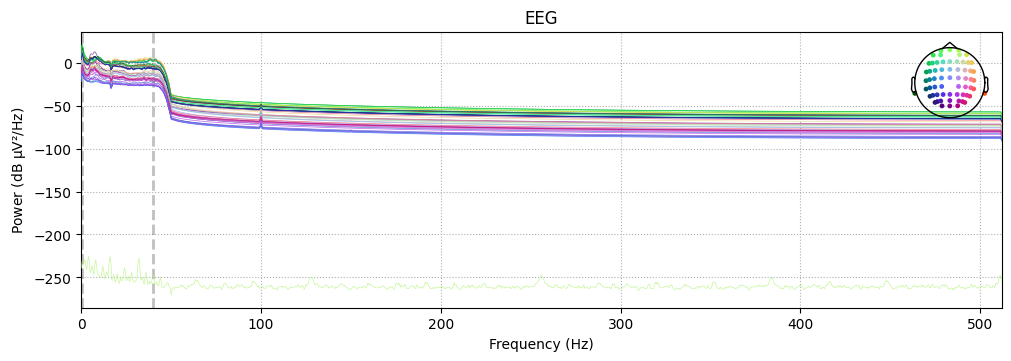

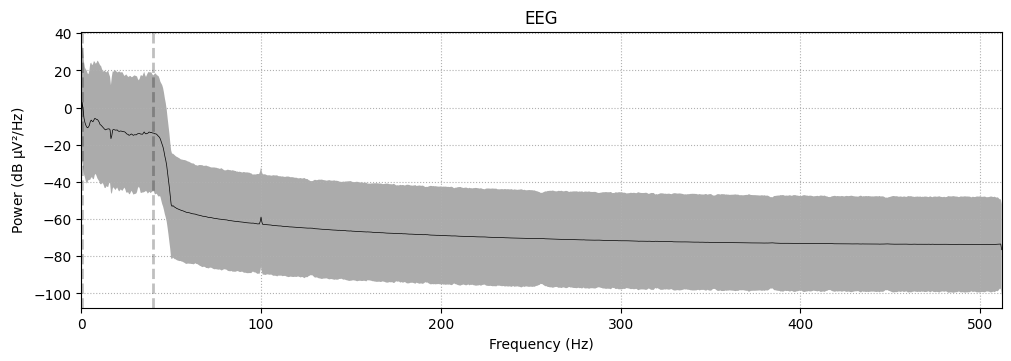

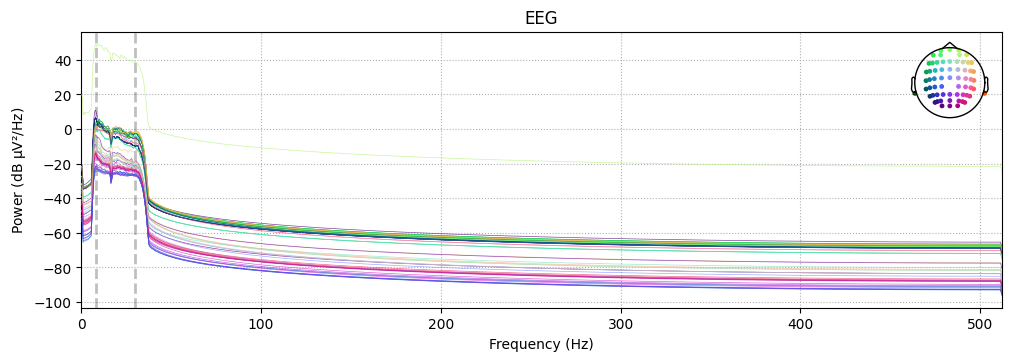

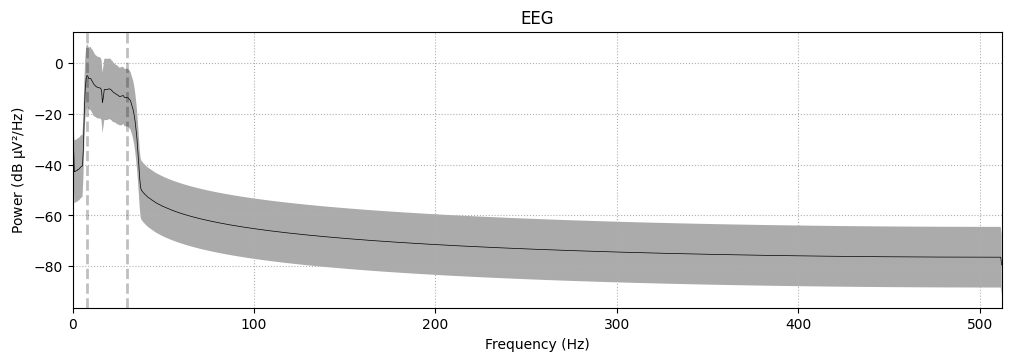

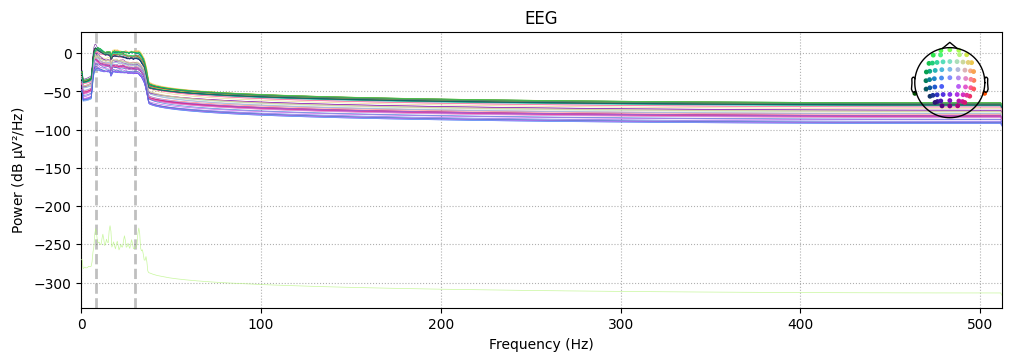

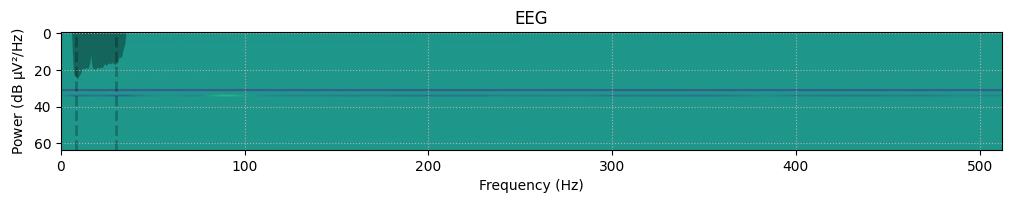

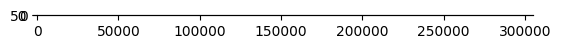

In [61]:
plt.imshow(raw_no_med.get_data())
plt.show()
plt.imshow(raw_no_med.copy().filter(1,10, verbose=False).get_data());
plt.show()
plt.plot(raw_no_med.copy().get_data()[40])
plt.plot(raw_no_med.copy().filter(8,30, verbose=False).get_data()[40])

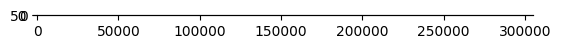

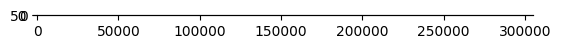

In [62]:
plt.imshow(raw_with_med.get_data())
plt.show()
plt.imshow(raw_with_med.copy().filter(1,10, verbose=False).get_data());
plt.show()
plt.plot(raw_with_med.copy().get_data()[40])
plt.plot(raw_with_med.copy().filter(8,30, verbose=False).get_data()[40])

# Next step

In [63]:
df_no_med = reconst_raw_no_med.to_data_frame()
print(df_no_med.head())
print(df_no_med.describe())

       time        Fp1        Fpz        Fp2          F7         F3  \
0  0.000000   0.000006   0.000099  -0.000112    0.001045   0.000628   
1  0.000977  27.159085  26.354172  26.634384   28.960629  12.993330   
2  0.001953  53.296490  51.722068  52.278774   56.834625  25.491254   
3  0.002930  77.448627  75.173672  75.999382   82.598278  37.028078   
4  0.003906  98.764386  95.888386  96.972240  105.346399  47.192464   

          Fz         F4          F8         FC5  ...           PO3        PO4  \
0   0.000677   0.001066    0.000112    0.000687  ... -6.512144e-08   0.000695   
1  -5.550111 -12.245659   30.117764   29.345182  ...  2.526518e+01   2.910069   
2 -10.882034 -24.016488   59.145091   57.600608  ...  4.959366e+01   5.702091   
3 -15.788474 -34.862308   86.052511   83.739610  ...  7.210123e+01   8.266029   
4 -20.087389 -44.387164  109.929085  106.854673  ...  9.200609e+01  10.504575   

         PO6         FT7         FT8        TP7        TP8        PO7  \
0  -0.000450 

In [64]:
df_with_med = reconst_raw_with_med.to_data_frame()
print(df_with_med.head())
print(df_with_med.describe())

       time        Fp1        Fpz        Fp2         F7         F3         Fz  \
0  0.000000   0.000083   0.000171  -0.000233  -0.000716   0.000060   0.001801   
1  0.000977   6.772568   5.316430   5.127572   4.053994   4.111716  -5.304402   
2  0.001953  13.303178  10.457898  10.087842   7.969872   8.040110 -10.414913   
3  0.002930  19.363516  15.259865  14.722813  11.614230  11.613380 -15.145072   
4  0.003906  24.752065  19.576868  18.893187  14.867485  14.682940 -19.330891   

          F4         F8        FC5  ...        PO3       PO4       PO6  \
0   0.002841   0.000140   0.000948  ...   0.000322 -0.000687 -0.000227   
1 -10.261222   5.849565   6.688704  ...   9.604333  2.048071  2.187655   
2 -20.134064  11.492572  13.033926  ...  18.885427  4.013135  4.286774   
3 -29.246754  16.737970  18.721088  ...  27.538228  5.815368  6.213208   
4 -37.273218  21.416429  23.481221  ...  35.289879  7.384755  7.892689   

         FT7        FT8        TP7        TP8        PO7       PO8  

In [65]:
df_no_med.shape[0]

305153

In [66]:
df_with_med.shape[0] 

305153

# Data export

In [67]:
#raw_no_med.save("patient_2024_02_21_raw_no_med.fif")
#raw_with_med.save("patient_2024_02_21_raw_with_med.fif")

In [68]:
#df_no_med.to_csv("df_no_med.csv")
#df_with_med.to_csv("df_with_med.csv")

In [69]:
df_no_med_transpose = df_no_med.transpose()
print(df_no_med_transpose.head())
df_no_med_np = df_no_med_transpose.to_numpy()
print((df_no_med_np))
print(len(df_no_med_np))

        0          1          2          3           4           5       \
time  0.000000   0.000977   0.001953   0.002930    0.003906    0.004883   
Fp1   0.000006  27.159085  53.296490  77.448627   98.764386  116.553914   
Fpz   0.000099  26.354172  51.722068  75.173672   95.888386  113.202465   
Fp2  -0.000112  26.634384  52.278774  75.999382   96.972240  114.530742   
F7    0.001045  28.960629  56.834625  82.598278  105.346399  124.343767   

          6           7           8           9       ...      305143  \
time    0.005859    0.006836    0.007812    0.008789  ...  297.991211   
Fp1   130.325026  139.805628  144.954353  145.956327  ...  107.233489   
Fpz   126.644207  135.956181  141.104471  142.273215  ...  109.064038   
Fp2   128.200707  137.722289  143.059773  144.395966  ...  112.341868   
F7    139.062290  149.204888  154.717079  155.785425  ...  104.735943   

          305144      305145      305146      305147      305148      305149  \
time  297.992188  297.993164  